#  EV Charging Station Data - Exploratory Data Analysis (EDA)

## Objective
The goal of this notebook is to perform Exploratory Data Analysis (EDA) on electric vehicle (EV) charging station data. This analysis helps uncover data quality issues, identify trends, and reveal patterns related to charger types, usage, and geographic distribution. Insights derived here will support decision-making for infrastructure planning and forecasting future demand.


### Required Libraries

Ensure the following Python libraries installed:
```bash
pip install pandas numpy matplotlib seaborn folium
```

In [1]:
pip install pandas matplotlib seaborn scipy folium


Note: you may need to restart the kernel to use updated packages.


### Step 1: Import Required Libraries and Load the Datasets

In [2]:
import zipfile
import os

# Define the path to the uploaded zip file and extraction path
zip_path = "./DataSets.zip"
extract_path = "./DataSets"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files to understand dataset contents
extracted_files = os.listdir(extract_path)
extracted_files


['DataSets']

In [3]:
import os

# Explore all files in the extracted directory
for root, dirs, files in os.walk("./DataSets"):
    for file in files:
        print(os.path.join(root, file))


./DataSets\DataSets\20100025.csv
./DataSets\DataSets\canadacities.csv
./DataSets\DataSets\ev_city_station_summary.csv
./DataSets\DataSets\plugs_detail.csv
./DataSets\DataSets\ports_detail.csv
./DataSets\DataSets\stations_detail.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets
df_ev = pd.read_csv("./DataSets/DataSets/20100025.csv")
df_cities = pd.read_csv("./DataSets/DataSets/canadacities.csv")
df_stations = pd.read_csv("./DataSets\DataSets\stations_detail.csv")



C:\Users\divya\AppData\Local\Temp\ipykernel_26688\899436478.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ev = pd.read_csv("./DataSets/DataSets/20100025.csv")


In [5]:

# Show basic info
print("Loaded datasets successfully.\n")

print("EV Registration Data:")
print(df_ev.shape)
print(df_ev.columns)

print("\nCharging Station Data:")
print(df_stations.shape)
print(df_stations.columns)

print("\nCity → Province Mapping:")
print(df_cities.shape)
print(df_cities.columns)



Loaded datasets successfully.

EV Registration Data:
(7055400, 17)
Index(['REF_DATE', 'GEO', 'DGUID', 'Fuel type', 'Vehicle type', 'Statistics',
       'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE',
       'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

Charging Station Data:
(27234, 34)
Index(['Id', 'IdAsString', 'IsShared', 'LocName', 'Address', 'StreetNo',
       'Street', 'City', 'ProvCode', 'ProvName', 'CountryCode', 'CountryName',
       'Zip', 'Lat', 'Long', 'Phone', 'Web', 'AccessId', 'AccessTime',
       'AccessOtherDesc', 'TotalPorts', 'AvailablePorts', 'NetworkId',
       'NetworkName', 'PriceNumber', 'PriceString', 'PriceStringInfo',
       'PriceStringSum', 'LocDesc', 'AccessType', 'StatusTime',
       'PaymentMethods', 'IsPassportEnabled', 'LocScore'],
      dtype='object')

City → Province Mapping:
(1737, 12)
Index(['city', 'city_ascii', 'province_id', 'province_name', 'lat', 'lng',
       'population', 'density', 't

### Step 2: Data Overview and Data Cleaning

#### Check missing values

In [6]:
# Step 3: Check missing values

print("Missing values in EV Registration Data:")
print(df_ev.isna().sum())

print("\nMissing values in Charging Station Data:")
print(df_stations.isna().sum())

print("\nMissing values in City Mapping Data:")
print(df_cities.isna().sum())


Missing values in EV Registration Data:
REF_DATE               0
GEO                    0
DGUID              17160
Fuel type              0
Vehicle type           0
Statistics             0
UOM                    0
UOM_ID                 0
SCALAR_FACTOR          0
SCALAR_ID              0
VECTOR                 0
COORDINATE             0
VALUE            3334485
STATUS           3720915
SYMBOL           7055400
TERMINATED       7055400
DECIMALS               0
dtype: int64

Missing values in Charging Station Data:
Id                       0
IdAsString               0
IsShared                 0
LocName                  0
Address                  0
StreetNo               772
Street                   2
City                     0
ProvCode                 0
ProvName                 0
CountryCode              0
CountryName              2
Zip                      0
Lat                      0
Long                     0
Phone                 4592
Web                   4282
AccessId             

In [7]:
# Drop non-essential columns from EV data
df_ev_clean = df_ev.drop(columns=["DGUID", "STATUS", "SYMBOL", "TERMINATED"])

# Remove rows with missing EV counts
df_ev_clean = df_ev_clean[df_ev_clean["VALUE"].notna()]

# Drop irrelevant columns from station data
cols_to_keep = ["City", "ProvName", "TotalPorts"]
df_stations_clean = df_stations[cols_to_keep].copy()

# Drop rows with missing city or province in station data
df_stations_clean = df_stations_clean.dropna(subset=["City", "ProvName"])

# Lowercase and strip spaces for matching later
df_ev_clean["GEO_clean"] = df_ev_clean["GEO"].str.strip().str.lower()
df_stations_clean["City_clean"] = df_stations_clean["City"].str.strip().str.lower()
df_cities["city_ascii_clean"] = df_cities["city_ascii"].str.strip().str.lower()

print("Cleaned datasets. Ready for merging.")


Cleaned datasets. Ready for merging.


### Step 3: Data Transformations

In [8]:
# Merge EV data with city-to-province mapping
df_ev_merged = df_ev_clean.merge(
    df_cities[["city_ascii_clean", "province_name"]],
    left_on="GEO_clean",
    right_on="city_ascii_clean",
    how="left"
)

# Filter only EV-related rows
ev_only = df_ev_merged[df_ev_merged["Fuel type"].isin(["Battery electric", "Plug-in hybrid electric"])]

# Group EVs by province and city
ev_summary = (
    ev_only.groupby(["province_name", "GEO"])["VALUE"]
    .sum()
    .reset_index()
    .rename(columns={"GEO": "City", "VALUE": "EV_Count"})
)

# Clean city names in EV summary for merge with station data
ev_summary["City_clean"] = ev_summary["City"].str.strip().str.lower()

print(" Merged and summarized EV registration data by city and province.")
print(ev_summary.head())


 Merged and summarized EV registration data by city and province.
      province_name        City  EV_Count  City_clean
0           Alberta    Cochrane      24.0    cochrane
1  British Columbia  Abbotsford   10376.0  abbotsford
2  British Columbia      Anmore     458.0      anmore
3  British Columbia   Armstrong      94.0   armstrong
4  British Columbia    Ashcroft       0.0    ashcroft


In [9]:
# Count total stations per city
station_counts = (
    df_stations_clean.groupby(["ProvName", "City_clean"])["TotalPorts"]
    .sum()
    .reset_index()
    .rename(columns={"ProvName": "province_name", "TotalPorts": "Station_Count"})
)

# Merge with EV data
ev_station_summary = ev_summary.merge(
    station_counts,
    on=["province_name", "City_clean"],
    how="left"
)

# Fill missing station counts with 0 (i.e., cities with EVs but no known stations)
ev_station_summary["Station_Count"] = ev_station_summary["Station_Count"].fillna(0).astype(int)

# Final preview
print("Merged EV data with charging station counts:")
print(ev_station_summary.head())


Merged EV data with charging station counts:
      province_name        City  EV_Count  City_clean  Station_Count
0           Alberta    Cochrane      24.0    cochrane             16
1  British Columbia  Abbotsford   10376.0  abbotsford            183
2  British Columbia      Anmore     458.0      anmore              2
3  British Columbia   Armstrong      94.0   armstrong              7
4  British Columbia    Ashcroft       0.0    ashcroft             11


### Step 4: Data Visualization

#### 1. EVs and Charging Stations per Province 

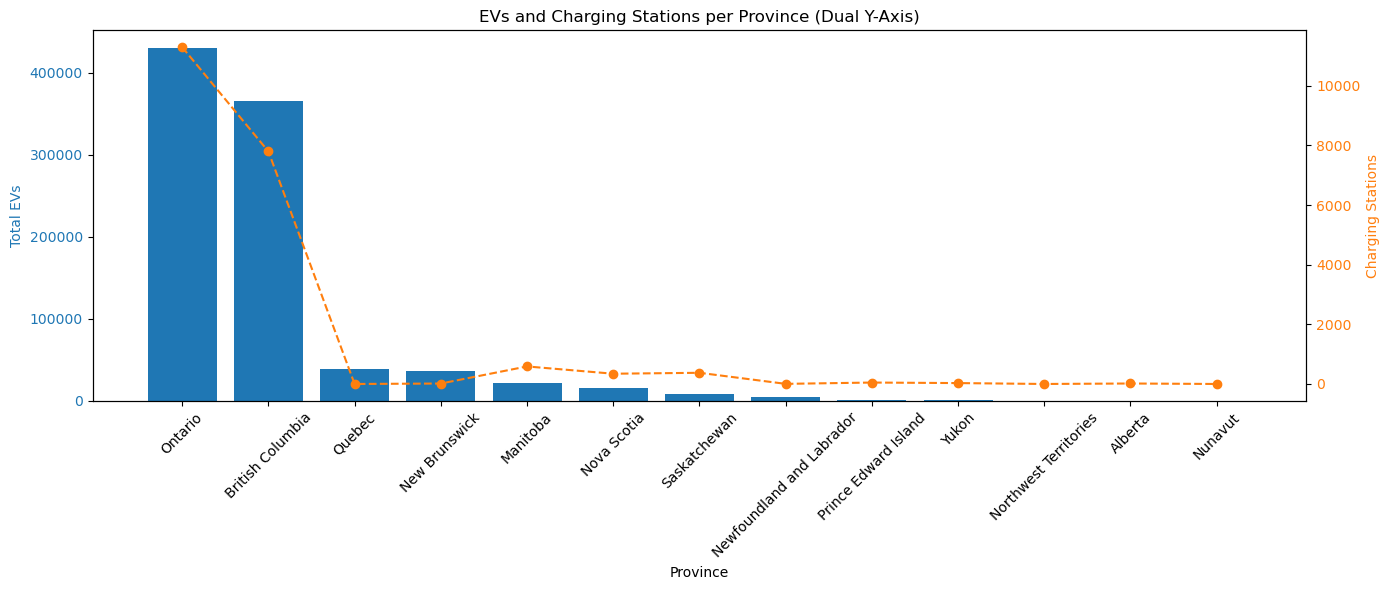

In [10]:
fig, ax1 = plt.subplots(figsize=(14, 6))
# Group by province to summarize totals
province_summary = (
    ev_station_summary.groupby("province_name")[["EV_Count", "Station_Count"]]
    .sum()
    .sort_values(by="EV_Count", ascending=False)
    .reset_index()
)

# EV Count
color = 'tab:blue'
ax1.set_xlabel('Province')
ax1.set_ylabel('Total EVs', color=color)
ax1.bar(province_summary["province_name"], province_summary["EV_Count"], color=color, label="Total EVs")
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Charging Stations on second Y-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Charging Stations', color=color)
ax2.plot(province_summary["province_name"], province_summary["Station_Count"], color=color, marker='o', linestyle='--', label="Charging Stations")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("EVs and Charging Stations per Province (Dual Y-Axis)")
fig.tight_layout()
plt.show()

##### Insights: 
- **EV Count (Bar Chart)** vs **Station Count (Line Plot)** per province.
- Ontario, Quebec, and British Columbia have the highest EV counts.
- Charging station availability doesn't scale linearly with EV growth—Ontario in particular shows imbalance.





#### 2. EVs per Charging Station

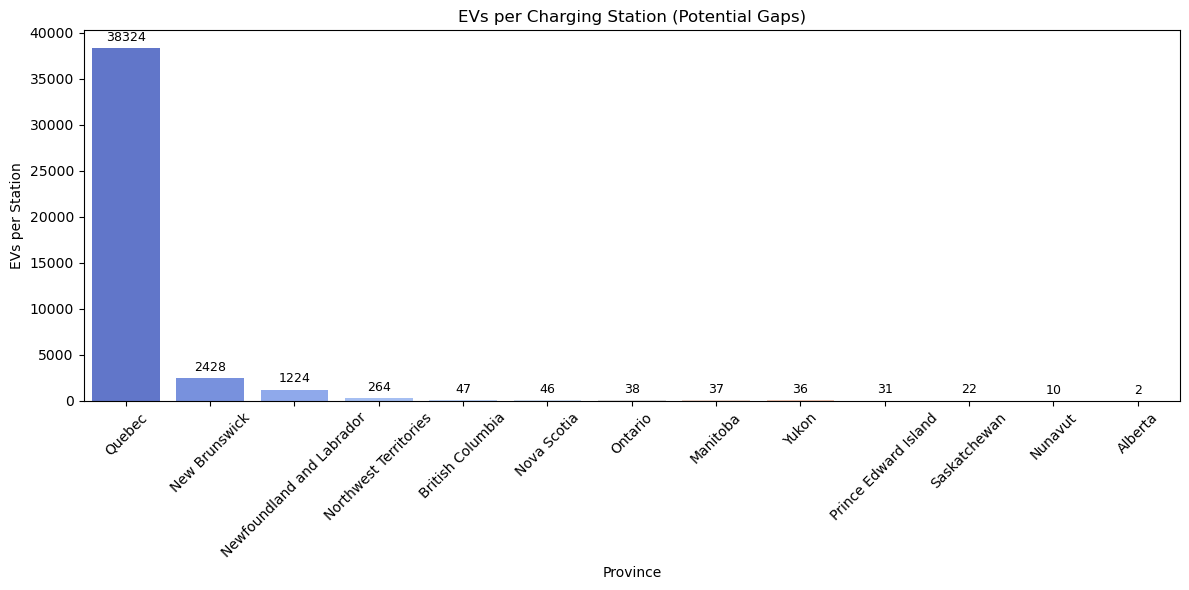

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

province_summary["EVs_per_Station"] = province_summary["EV_Count"] / province_summary["Station_Count"].replace(0, 1)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=province_summary.sort_values("EVs_per_Station", ascending=False),
    x="province_name",
    y="EVs_per_Station",
    palette="coolwarm"
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=3)

plt.title("EVs per Charging Station (Potential Gaps)")
plt.ylabel("EVs per Station")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



##### Insights: 
- Shows **efficiency/load** on infrastructure per province.
- Ontario and Alberta have high EVs per station → infrastructure **stress points**.
- Quebec and BC show more balanced deployment.



#### 3. EV Registrations vs Charging Station Availability by Province in Canada

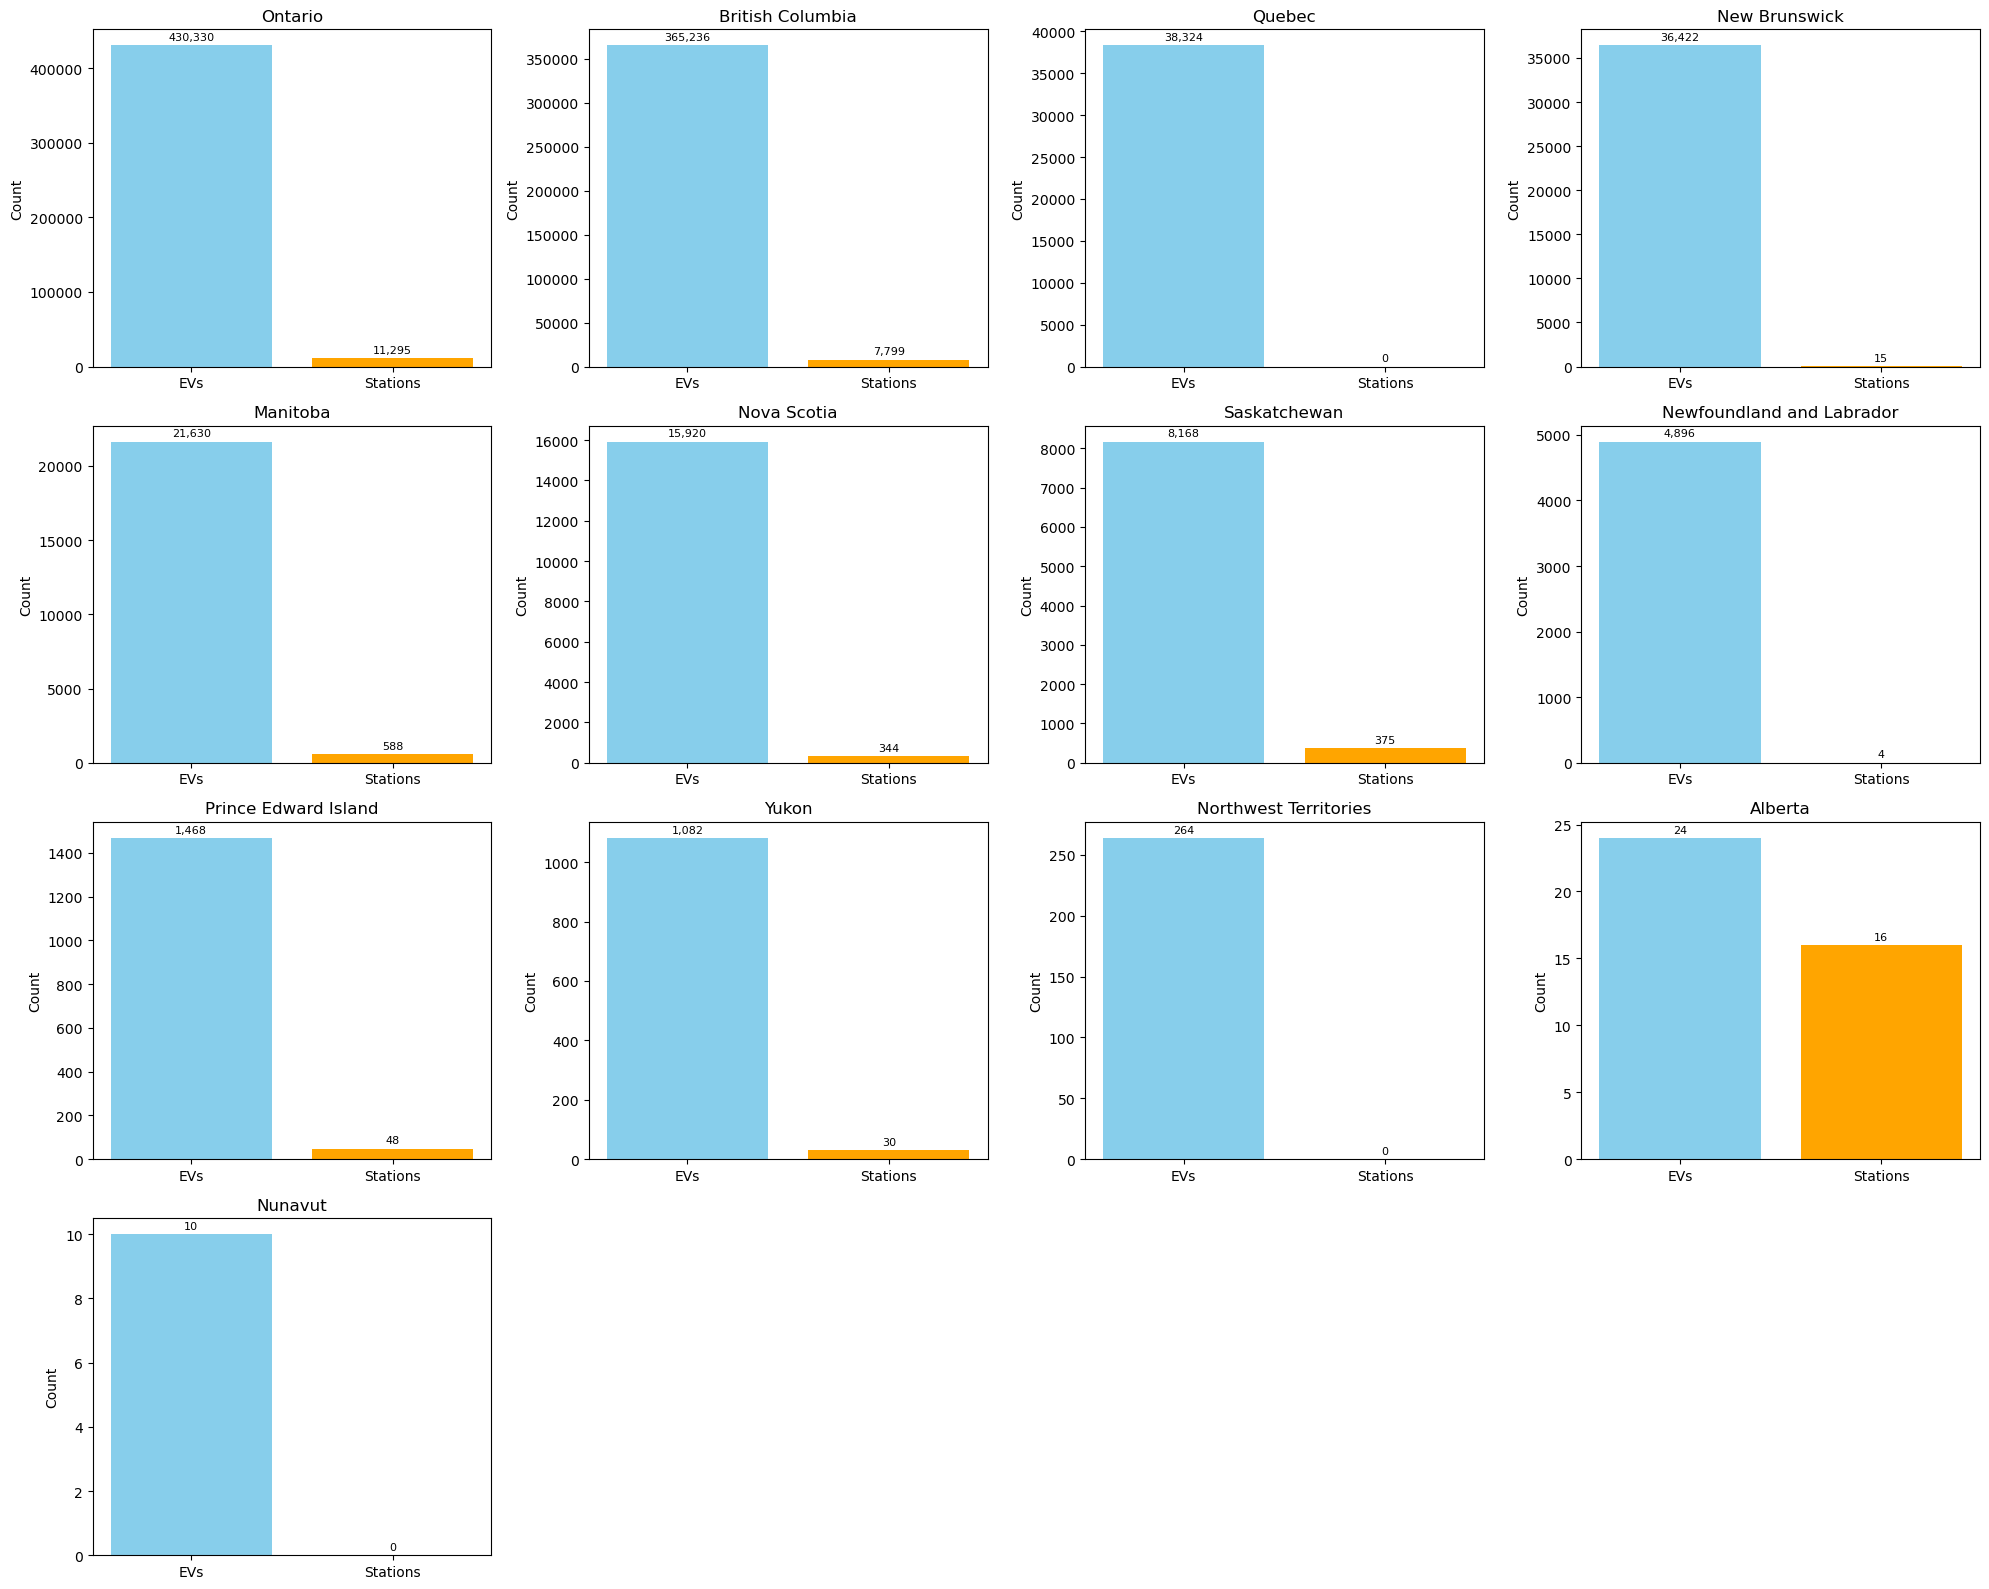

In [12]:
provinces = province_summary["province_name"].tolist()
cols = 4
rows = -(-len(provinces) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for i, province in enumerate(provinces):
    ax = axes[i]
    evs = province_summary.loc[province_summary["province_name"] == province, "EV_Count"].values[0]
    stations = province_summary.loc[province_summary["province_name"] == province, "Station_Count"].values[0]

    bars = ax.bar(["EVs", "Stations"], [evs, stations], color=["skyblue", "orange"])
    ax.set_title(province)
    ax.set_ylabel("Count")

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + max(evs, stations)*0.01, f'{int(height):,}', 
                ha='center', va='bottom', fontsize=8)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### EVs vs Charging Stations by Province – What This Shows

This chart compares how many EVs each province has versus how many charging stations are available. Here's why it matters:

- **Some provinces have EVs but almost no chargers** — like New Brunswick, Quebec, and Nunavut.
- **Bigger provinces like Ontario and BC have more chargers**, but still not enough compared to their EV count.
- **This shows a big gap in rural and remote areas**, where infrastructure is missing.
- **It supports our need to build a Rural EV Demand Forecasting Tool** to help plan where new chargers should go.
- **This helps us decide which provinces need help first**, and where to focus pilot projects and dashboard data.

> Overall, this proves that Canada needs better planning for rural EV charging, not just city-focused solutions.


##### 4. Ontario City-wise EVs and Charging Stations

In [13]:
# Filter data for Ontario
ontario_ev = ev_summary[ev_summary["province_name"] == "Ontario"]
ontario_stations = df_stations[df_stations["ProvName"] == "Ontario"]


# Clean city names for matching
ontario_ev["City_clean"] = ontario_ev["City"].str.strip().str.lower()
ontario_stations["City_clean"] = ontario_stations["City"].str.strip().str.lower()

# Count charging stations by city
ontario_station_counts = (
    ontario_stations.groupby("City_clean")
    .size()
    .reset_index(name="Station_Count")
)

# Merge EVs with station counts
ontario_city_stats = ontario_ev.merge(ontario_station_counts, on="City_clean", how="left")
ontario_city_stats["Station_Count"] = ontario_city_stats["Station_Count"].fillna(0).astype(int)

# Sort by EV count
ontario_city_stats = ontario_city_stats.sort_values(by="EV_Count", ascending=False)

# Display final city-wise EVs and stations
print("\n Ontario City-wise EVs and Charging Stations:\n")
print(ontario_city_stats[["City", "EV_Count", "Station_Count"]].head(20))



 Ontario City-wise EVs and Charging Stations:

              City  EV_Count  Station_Count
295        Toronto   82760.0            428
210         Ottawa   34274.0            219
173    Mississauga   30254.0            179
161        Markham   21814.0             62
35        Brampton   21630.0             76
301        Vaughan   17928.0             54
203       Oakville   17920.0             85
113       Hamilton   16036.0             77
237  Richmond Hill   15268.0             26
150         London    9036.0            113
43      Burlington    8978.0             82
138      Kitchener    7576.0             59
171         Milton    6288.0             19
4             Ajax    5226.0             26
305       Waterloo    4970.0             64
208         Oshawa    4784.0             38
315         Whitby    4740.0             40
183      Newmarket    4462.0             24
20          Aurora    4160.0             19
110         Guelph    4132.0             54


C:\Users\divya\AppData\Local\Temp\ipykernel_26688\963617004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ontario_ev["City_clean"] = ontario_ev["City"].str.strip().str.lower()
C:\Users\divya\AppData\Local\Temp\ipykernel_26688\963617004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ontario_stations["City_clean"] = ontario_stations["City"].str.strip().str.lower()


##### Insights:
- Toronto, Ottawa, Mississauga lead in EV adoption.
- Some cities show relatively **low station availability** despite high EV numbers.


#### 5.EVs vs Charging Stations in Ontario Cities

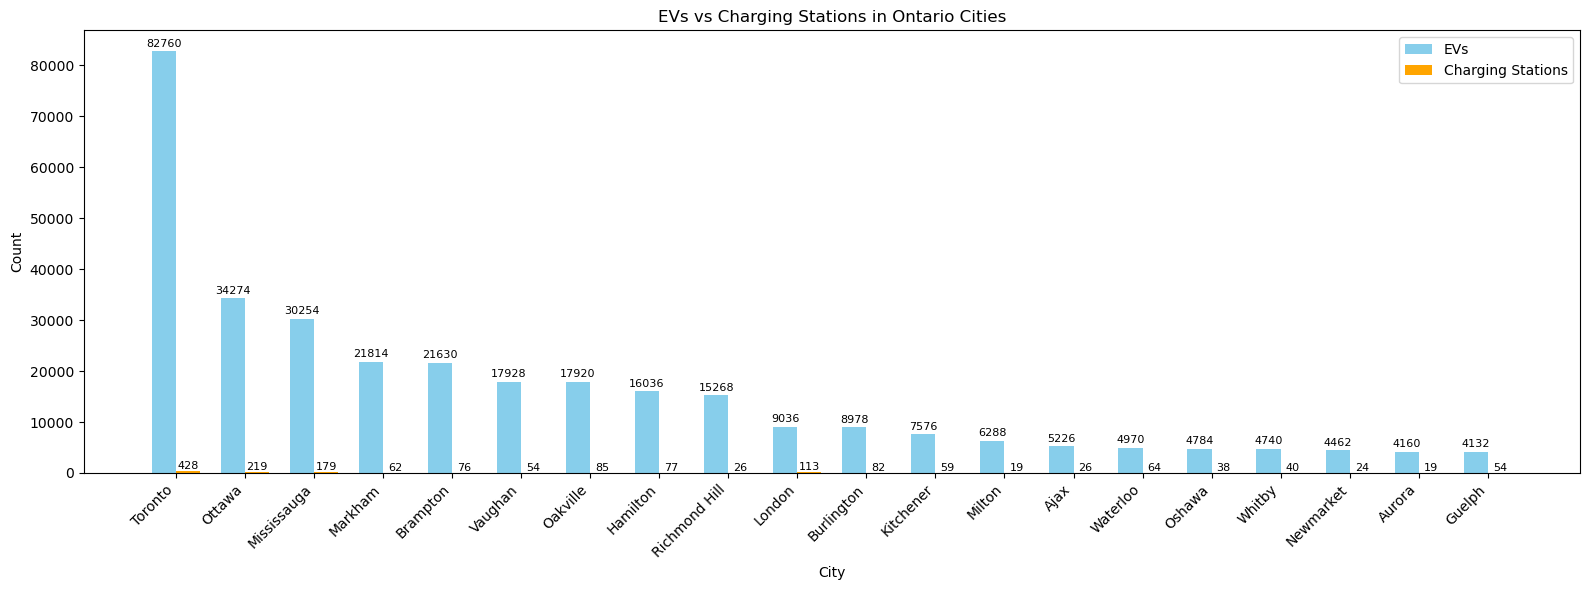

In [14]:

# Take top 20 cities from the data
top_ontario = ontario_city_stats.head(20)

# Set up positions for grouped bars
x = np.arange(len(top_ontario["City"]))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(16, 6))
ev_bars = ax.bar(x - width/2, top_ontario["EV_Count"], width, label="EVs", color="skyblue")
station_bars = ax.bar(x + width/2, top_ontario["Station_Count"], width, label="Charging Stations", color="orange")

# Labels and title
ax.set_xlabel("City")
ax.set_ylabel("Count")
ax.set_title("EVs vs Charging Stations in Ontario Cities")
ax.set_xticks(x)
ax.set_xticklabels(top_ontario["City"], rotation=45, ha="right")
ax.legend()

# Annotate bar values
for bar in ev_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 500, int(yval), ha='center', va='bottom', fontsize=8)

for bar in station_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### EV vs Charging Stations – Ontario Cities: Why It Matters

This bar chart compares the number of electric vehicles (EVs) with available charging stations across major cities in Ontario. It offers several key insights that support our project objectives:

- **Infrastructure Imbalance:** Cities like Toronto, Ottawa, and Mississauga show a disproportionately high number of EVs compared to available charging stations, indicating infrastructure stress even in urban areas.
  
- **Benchmarking Rural Gaps:** These urban benchmarks can serve as reference points to identify how much more underserved rural cities are in comparison (e.g., a rural city with 500 EVs but only 2 chargers vs Toronto’s 428 chargers for 82,760 EVs).

- **Demand Clustering:** This helps identify zones with high EV demand but low charging coverage, which can then be modeled and compared against rural demand clusters.

- **Model Calibration:** Data from these cities can be used to train the Rural Demand Forecasting Tool—especially in understanding thresholds for infrastructure adequacy.

- **Deployment Guidance:** Helps set a minimum viable charger-to-EV ratio that can be adapted for rural zones when building the GapMap or selecting pilot locations.

>  This comparison reinforces the need for a predictive model that doesn't just track growth, but proactively addresses **where** to install chargers before demand exceeds supply—especially in rural or suburban Ontario regions currently flying under the radar.


#### 6. EV Distribution by Province and City

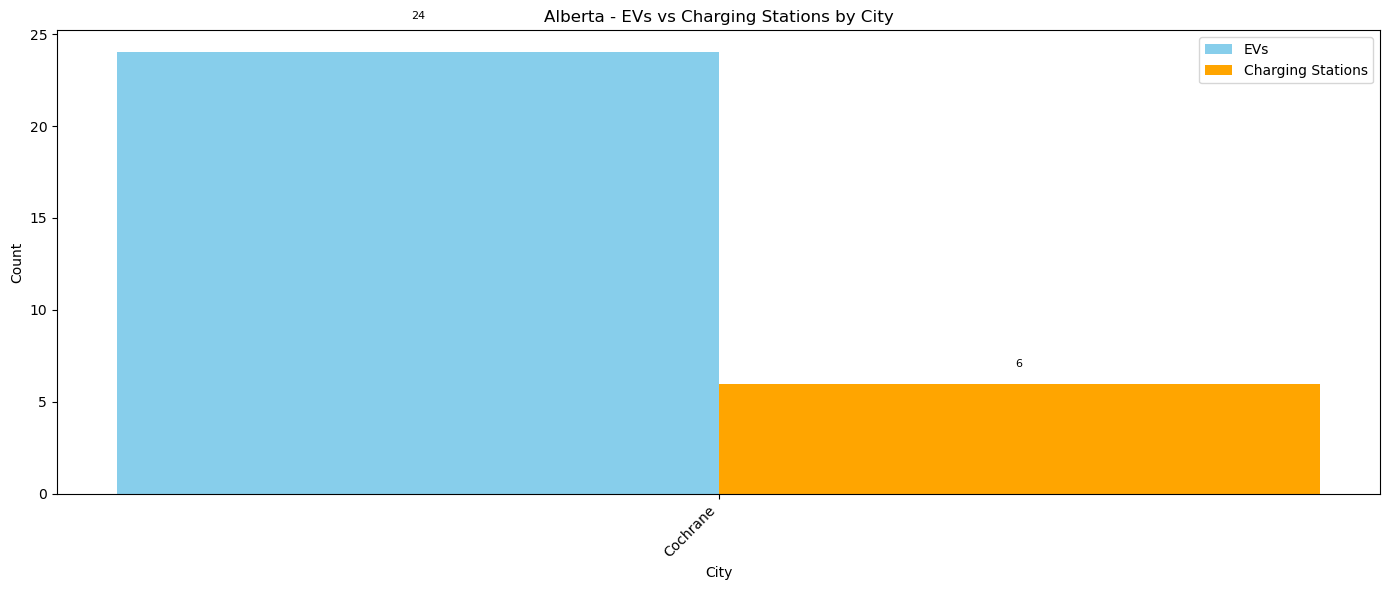

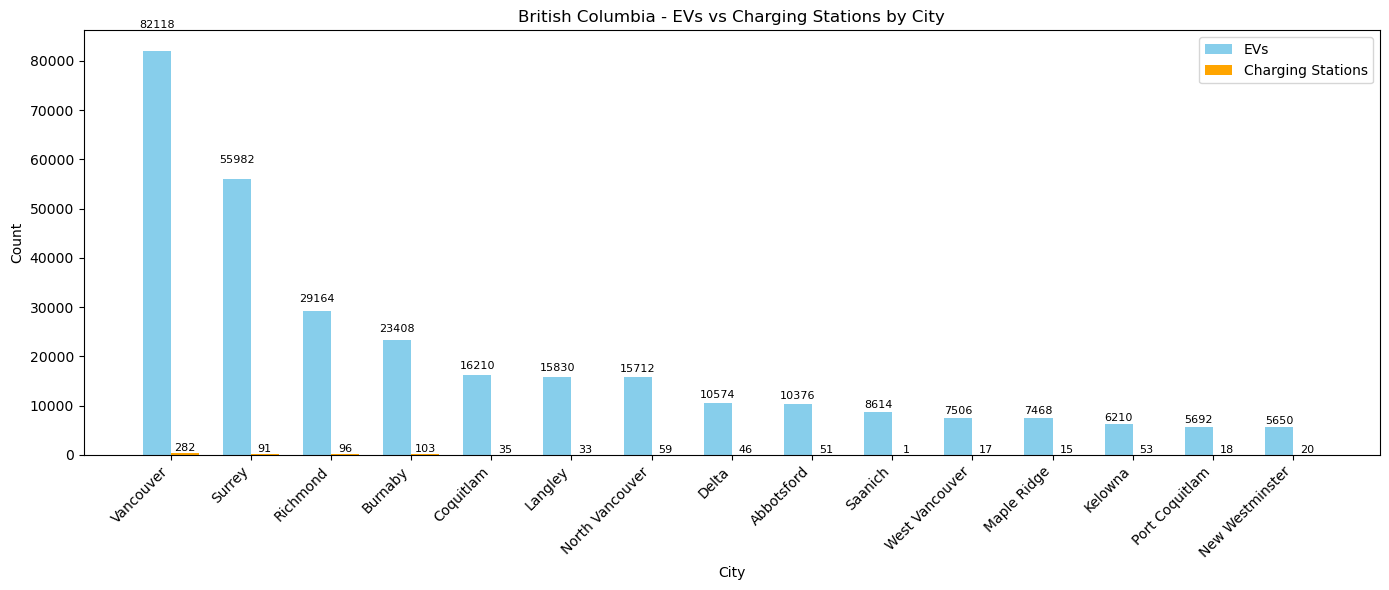

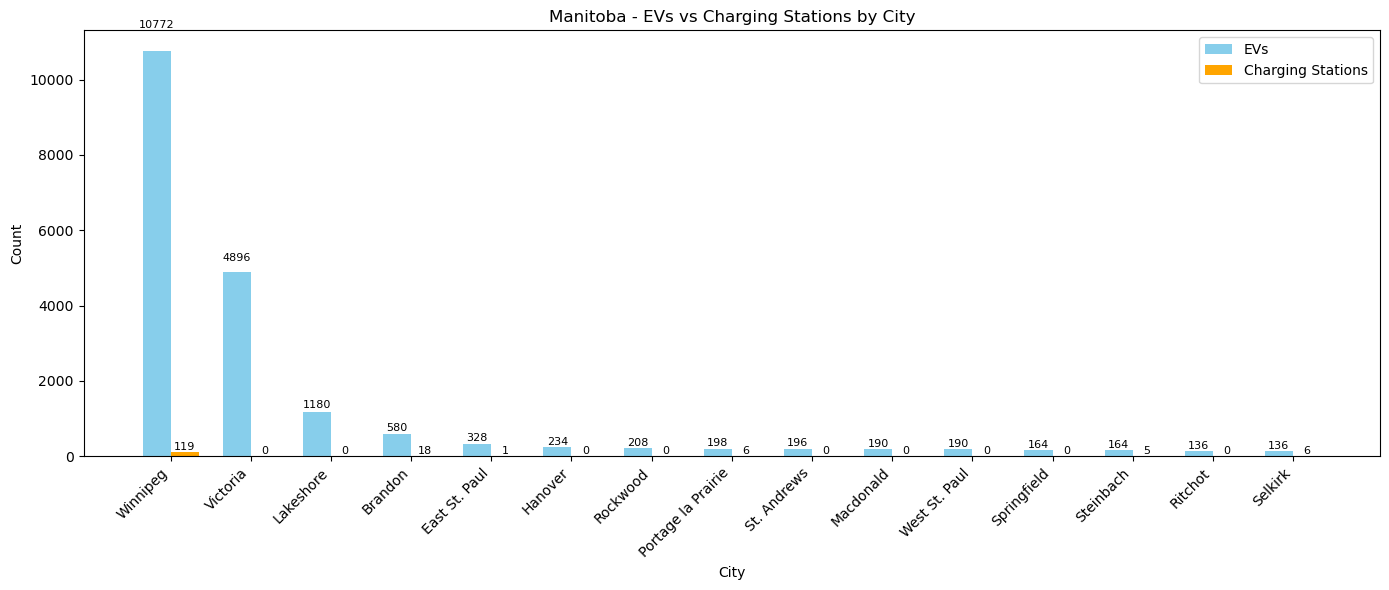

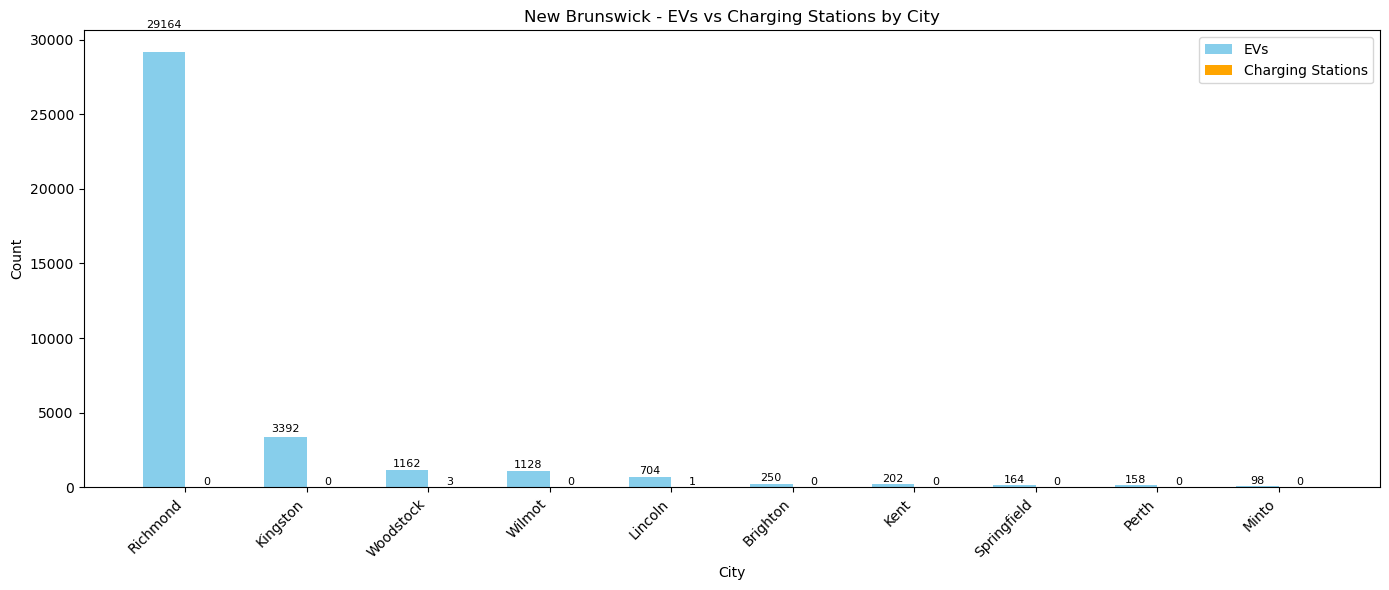

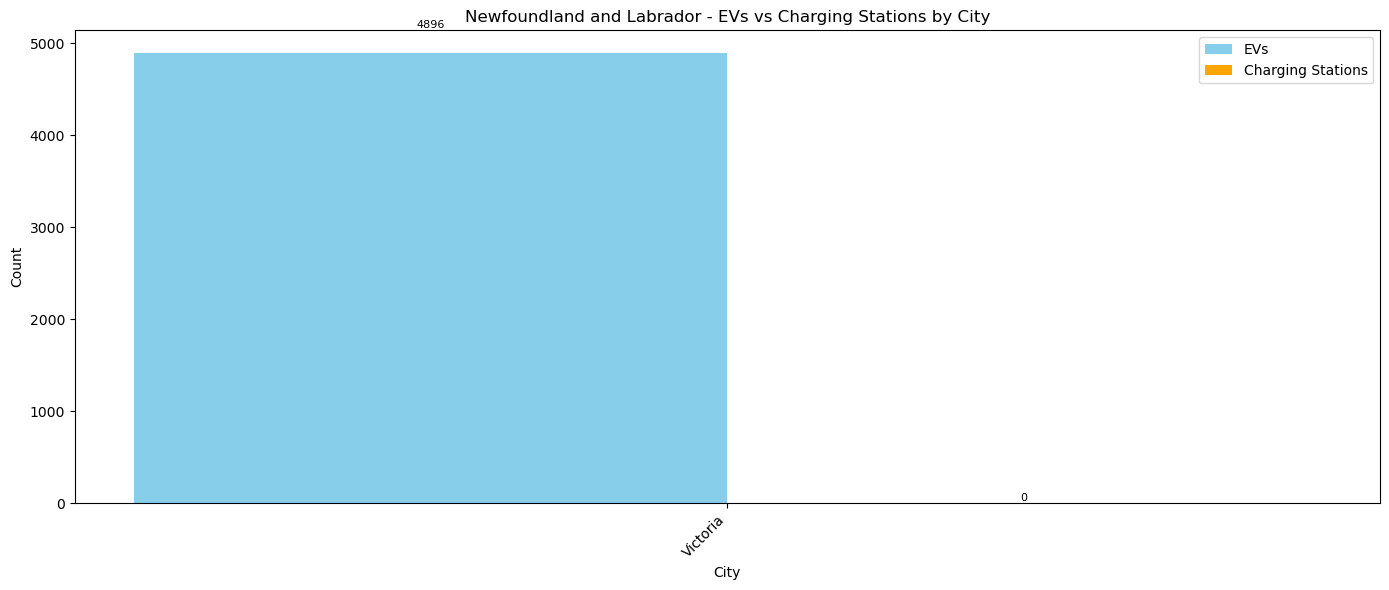

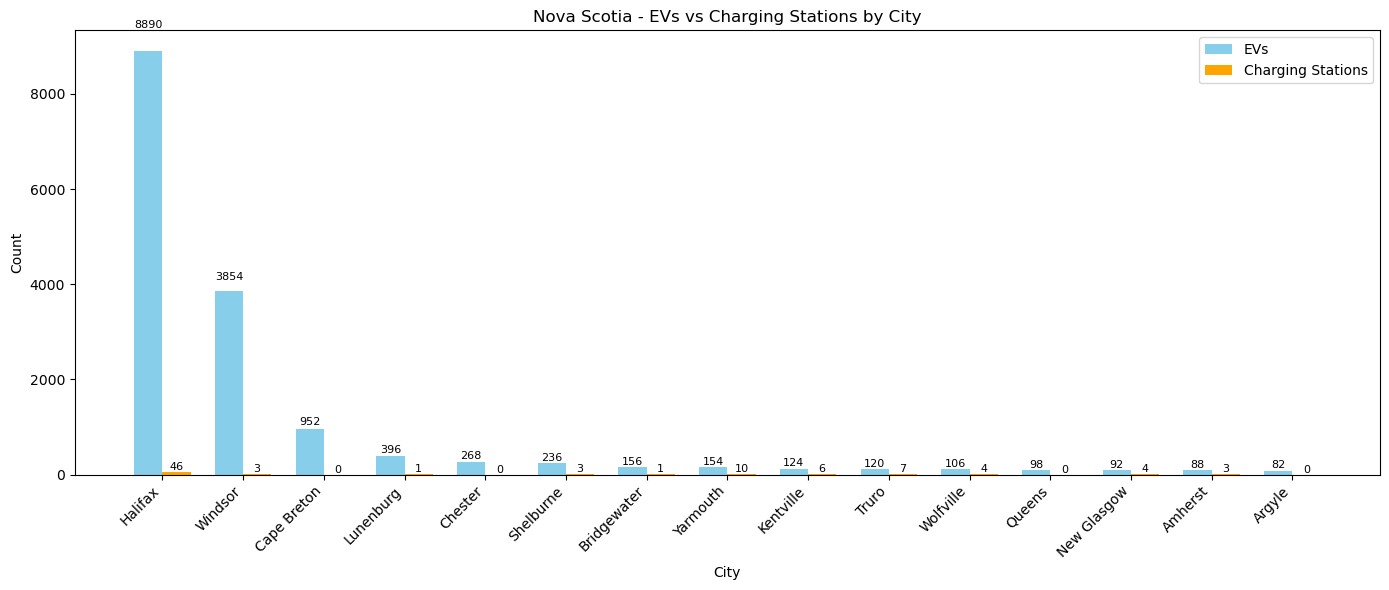

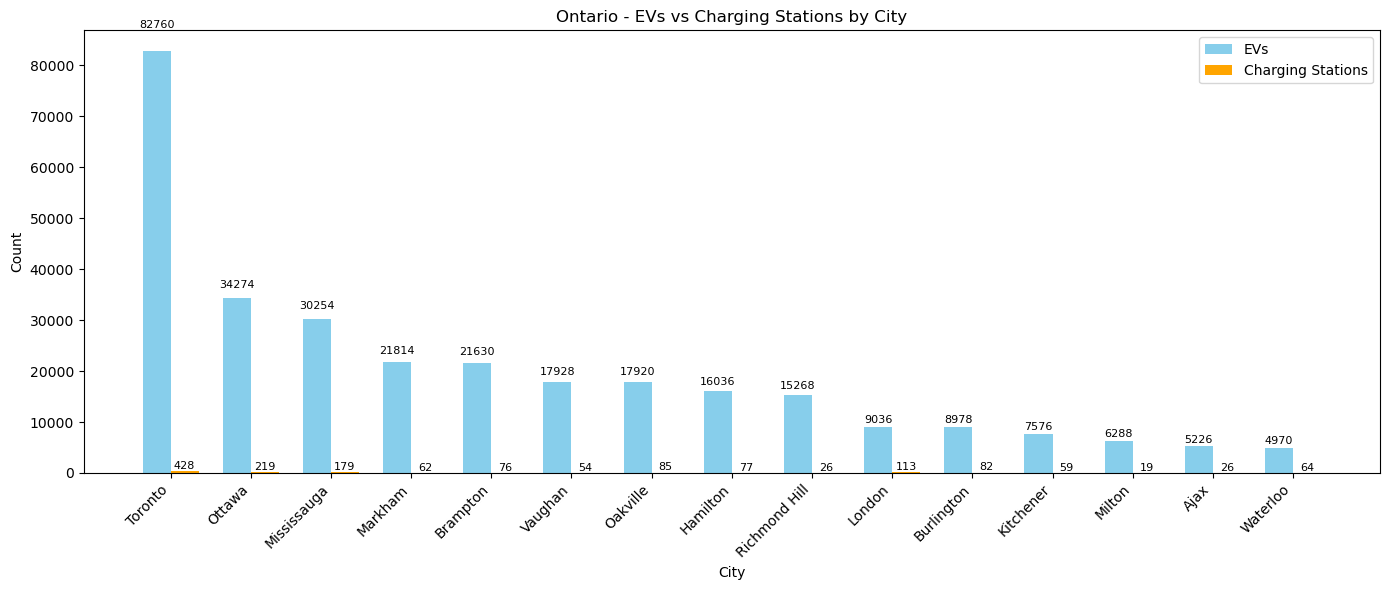

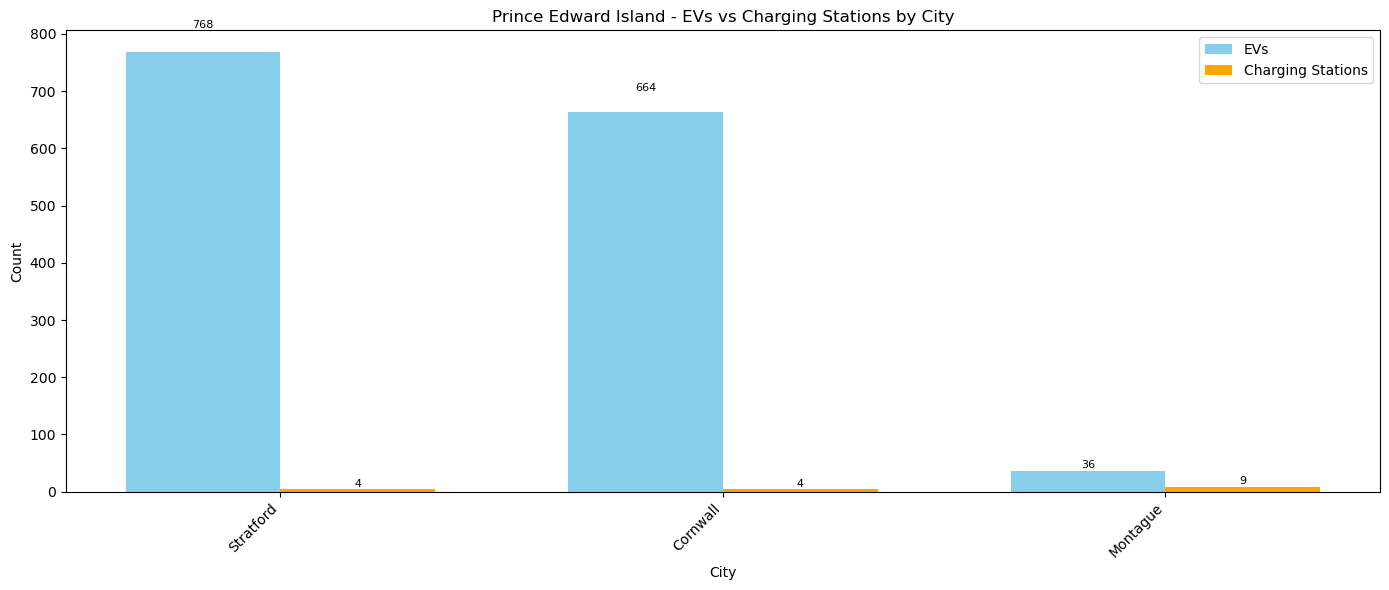

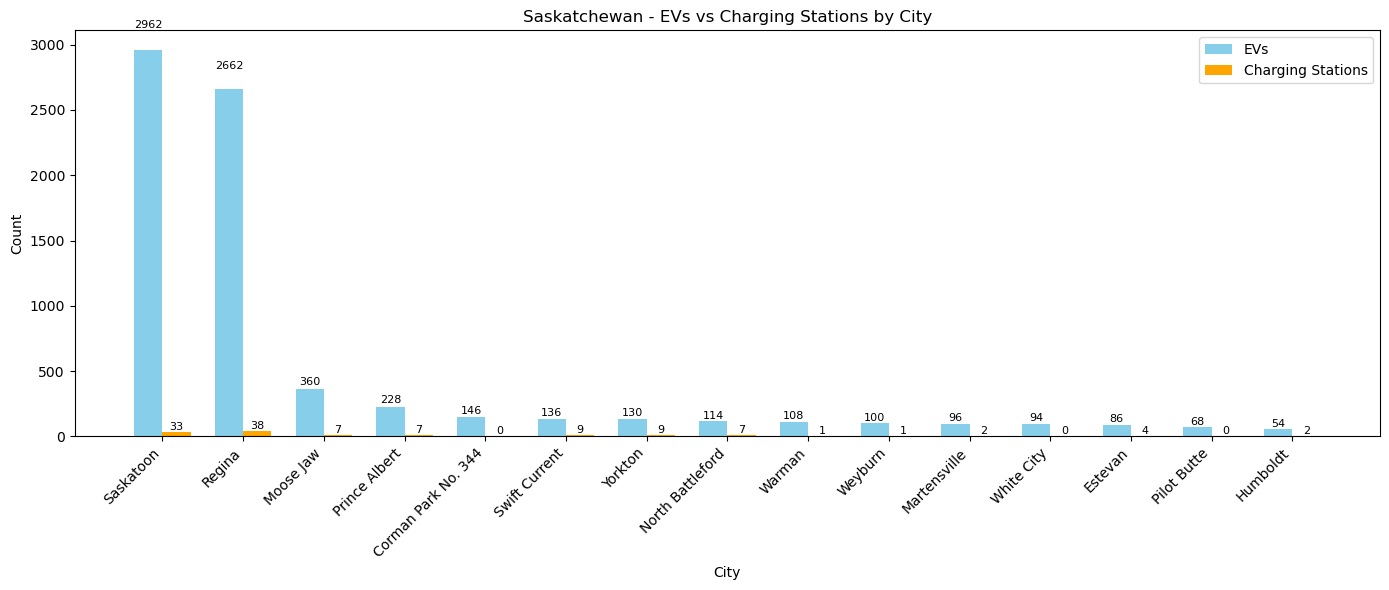

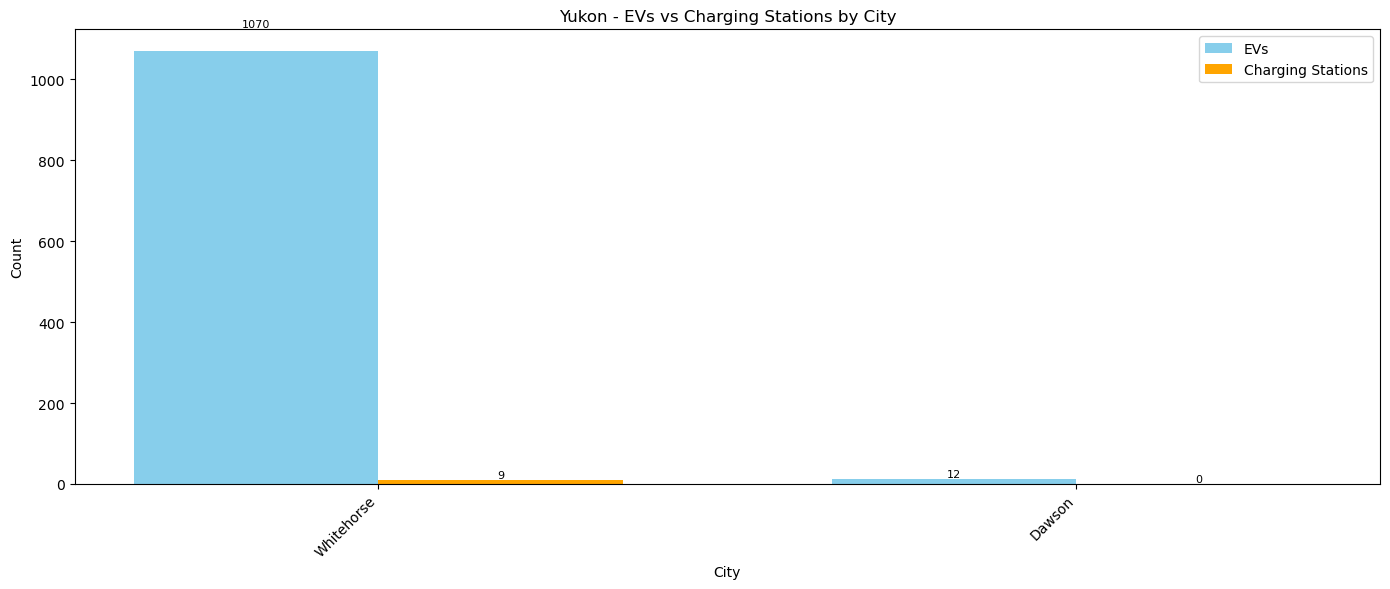

In [15]:

# Filter valid provinces
valid_provinces = ev_summary["province_name"].dropna().unique()

# Prepare cleaned station data for merging
df_stations["City_clean"] = df_stations["City"].str.strip().str.lower()
df_stations["province_name"] = df_stations["ProvName"]

# Generate charts for each province
for province in valid_provinces:
    ev_df = ev_summary[ev_summary["province_name"] == province].copy()
    station_df = df_stations[df_stations["province_name"] == province].copy()

    if ev_df.empty or station_df.empty:
        continue  # Skip provinces with no EV or station data

    ev_df["City_clean"] = ev_df["City"].str.strip().str.lower()
    station_df["City_clean"] = station_df["City"].str.strip().str.lower()

    # Count charging stations by city
    station_counts = (
        station_df.groupby("City_clean")
        .size()
        .reset_index(name="Station_Count")
    )

    # Merge EV and station counts
    merged = ev_df.merge(station_counts, on="City_clean", how="left")
    merged["Station_Count"] = merged["Station_Count"].fillna(0).astype(int)
    merged = merged[merged["EV_Count"] > 0]  # Filter cities with EVs
    merged = merged.sort_values(by="EV_Count", ascending=False).head(15)

    if merged.empty:
        continue  # Skip if no city has EVs

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(merged))
    width = 0.35

    bars1 = ax.bar(x - width/2, merged["EV_Count"], width, label="EVs", color="skyblue")
    bars2 = ax.bar(x + width/2, merged["Station_Count"], width, label="Charging Stations", color="orange")

    ax.set_title(f"{province} - EVs vs Charging Stations by City")
    ax.set_xlabel("City")
    ax.set_ylabel("Count")
    ax.set_xticks(x)
    ax.set_xticklabels(merged["City"], rotation=45, ha="right")
    ax.legend()

    # Annotate bars safely relative to their height
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + height * 0.05 + 0.5, f"{int(height)}", 
                ha='center', va='bottom', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + height * 0.05 + 0.5, f"{int(height)}", 
                ha='center', va='bottom', fontsize=8)


    plt.tight_layout()
    plt.show()


#### 7. Top 10 Underserved Cities by Gap Score:

In [16]:
all_gap_scores = []

# 🧼 Clean once outside loop
df_stations["City_clean"] = df_stations["City"].str.strip().str.lower()
df_stations["province_name"] = df_stations["ProvName"].str.strip().str.lower()

ev_summary["City_clean"] = ev_summary["City"].str.strip().str.lower()
ev_summary["province_name"] = ev_summary["province_name"].str.strip().str.lower()

# 🎯 Loop through each province
valid_provinces = ev_summary["province_name"].dropna().unique()

for province in valid_provinces:
    ev_df = ev_summary[ev_summary["province_name"] == province].copy()
    station_df = df_stations[df_stations["province_name"] == province].copy()

    # 📊 Count stations per city
    station_counts = (
        station_df.groupby("City_clean")
        .size()
        .reset_index(name="Station_Count")
    )

    # 🔗 Merge EV and station data
    merged = ev_df.merge(station_counts, on="City_clean", how="left")
    merged["Station_Count"] = merged["Station_Count"].fillna(0).astype(int)

    # ⚙️ Compute Gap Score for all cities
    merged["GapScore"] = merged["EV_Count"] / (merged["Station_Count"] + 1)

    # 📦 Collect relevant columns
    gap_df = merged[["City", "province_name", "EV_Count", "Station_Count", "GapScore"]]
    all_gap_scores.append(gap_df)

# 🧩 Combine data across all provinces
final_gap_df = pd.concat(all_gap_scores, ignore_index=True).drop_duplicates()

# 🔝 Sort and show top 10 underserved cities
top_gap = final_gap_df.sort_values("GapScore", ascending=False).head(10)

print(" Top 10 Underserved Cities by Gap Score:")
print(top_gap)

 Top 10 Underserved Cities by Gap Score:
           City              province_name  EV_Count  Station_Count  GapScore
628    Richmond                     quebec   29164.0              0   29164.0
246    Richmond              new brunswick   29164.0              0   29164.0
631    Waterloo                     quebec    4970.0              0    4970.0
251    Victoria  newfoundland and labrador    4896.0              0    4896.0
227    Victoria                   manitoba    4896.0              0    4896.0
93      Saanich           british columbia    8614.0              1    4307.0
632     Windsor                     quebec    3854.0              0    3854.0
242    Kingston              new brunswick    3392.0              0    3392.0
361  Clarington                    ontario    2542.0              0    2542.0
434        King                    ontario    2004.0              0    2004.0


#### 8. Top 10 Underserved Cities by Gap Score (EVs vs Charging Stations )

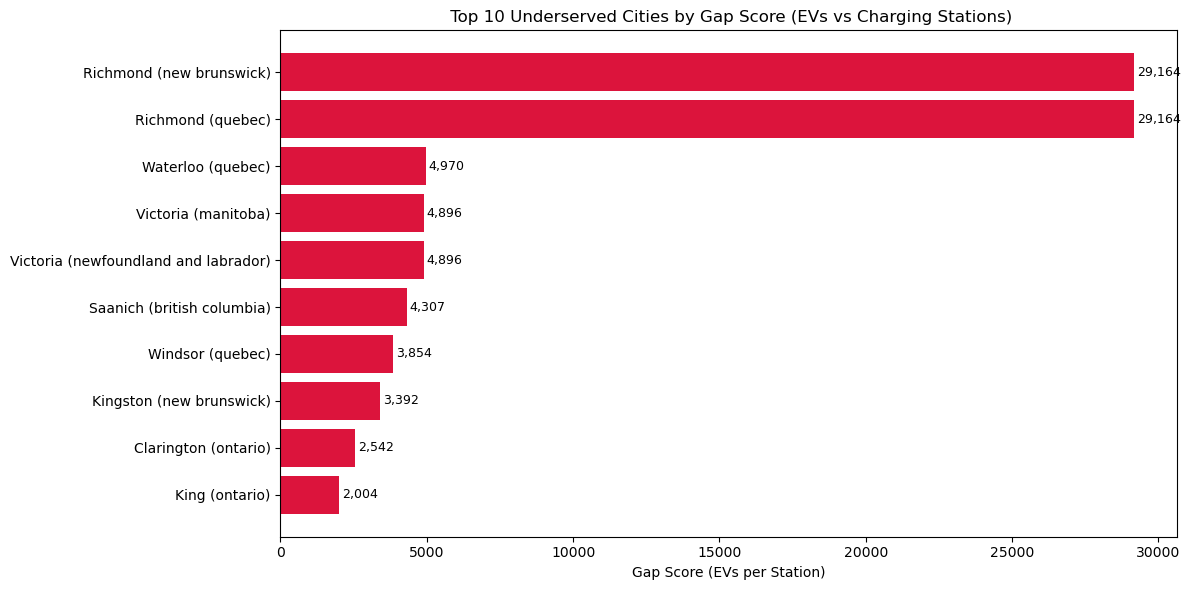

In [17]:

# Sort again just to ensure descending order
top_gap_sorted = top_gap.sort_values(by="GapScore", ascending=True)

plt.figure(figsize=(12, 6))
bars = plt.barh(
    top_gap_sorted["City"] + " (" + top_gap_sorted["province_name"] + ")",
    top_gap_sorted["GapScore"],
    color="crimson"
)

# Annotate values on bars
for bar in bars:
    plt.text(
        bar.get_width() + 100,
        bar.get_y() + bar.get_height()/2,
        f"{int(bar.get_width()):,}",
        va="center",
        fontsize=9
    )

plt.title(" Top 10 Underserved Cities by Gap Score (EVs vs Charging Stations)")
plt.xlabel("Gap Score (EVs per Station)")
plt.tight_layout()
plt.show()


###  Why Identifying Top Underserved Cities Matters for the Forecasting Tool

Identifying the top underserved cities based on EVs per charging station is a foundational step in training the **Rural EV Demand Forecasting Tool**. Here's how it supports the overall system:

- **Prioritization:** Pinpoints rural cities with the greatest EV infrastructure gap (e.g., Richmond NB & QC, Waterloo QC), guiding where interventions are most urgent.
- **Data Anchoring:** Supplies real-world, high-gap examples to inform supervised learning for demand prediction.
- **Localized Input:** Enables modeling based on actual rural mobility factors like travel behavior, registration trends, and population changes.
- **Forecast Accuracy:** Enhances predictive accuracy by learning from extreme cases of infrastructure shortage.
- **Site Planning:** Informs pilot site selection and dashboard filters for underserved zones.
- **Policy Support:** Strengthens data-driven advocacy for equitable EV deployment in rural Canada.




#### 9.Top Underserved Cities Map

In [18]:

import folium
from folium.plugins import MarkerCluster


#  Clean city names for merge
df_cities["City_clean"] = df_cities["city"].str.strip().str.lower()
top_gap["City_clean"] = top_gap["City"].str.strip().str.lower()

# Merge lat/lng into top_gap
top_gap_coords = top_gap.merge(
    df_cities[["City_clean", "province_name", "lat", "lng"]],
    on=["City_clean", "province_name"],
    how="left"
)

# Remove rows without coordinates
top_gap_coords = top_gap_coords.dropna(subset=["lat", "lng"])

# Create base map centered on Canada
canada_map = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# Initialize marker cluster
marker_cluster = MarkerCluster().add_to(canada_map)

# Add markers
for _, row in top_gap_coords.iterrows():
    city = row['City']
    province = row['province_name']
    gap_score = row['GapScore']
    ev_count = row['EV_Count']
    stations = row['Station_Count']
    lat = row['lat']
    lon = row['lng']

    popup_text = (
        f"<b>{city}, {province}</b><br>"
        f"EVs: {int(ev_count)}<br>"
        f"Charging Stations: {int(stations)}<br>"
        f"Gap Score: {gap_score:.1f}"
    )

    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(marker_cluster)

# ✅ Save the map to an HTML file
canada_map.save('Top_Underserved_Cities_Map.html')
print(" Map saved as 'Top_Underserved_Cities_Map.html'")


 Map saved as 'Top_Underserved_Cities_Map.html'


| Gap Score | Meaning           | Marker Color |
| --------- | ----------------- | ------------ |
| > 500     | 🚨 Critical Gap   | Red          |
| 300–500   | ⚠️ Moderate Gap   | Orange       |
| 100–300   | ⚙️ Manageable Gap | Blue         |
| < 100     | ✅ Balanced        | Green        |


#### 10. All Cities GapScore Map

In [19]:

#  Step 1: Clean city and province names for consistent matching
final_gap_df["City_clean"] = final_gap_df["City"].str.strip().str.lower()
final_gap_df["province_name"] = final_gap_df["province_name"].str.strip().str.lower()

df_cities["City_clean"] = df_cities["city"].str.strip().str.lower()
df_cities["province_name"] = df_cities["province_name"].str.strip().str.lower()

# Step 2: Merge coordinates
gap_coords = final_gap_df.merge(
    df_cities[["City_clean", "province_name", "lat", "lng"]],
    on=["City_clean", "province_name"],
    how="left"
).dropna(subset=["lat", "lng"])

# Optional: Print how many matched
print("Matched cities with coordinates:", len(gap_coords))

#  Step 3: Define gap score color category
def get_marker_color(score):
    if score > 500:
        return "red"       #  Critical Gap
    elif score > 300:
        return "orange"    #  Moderate Gap
    elif score > 100:
        return "blue"      #  Manageable Gap
    else:
        return "green"     #  Balanced

#  Step 4: Create folium map
canada_map = folium.Map(location=[56.1304, -106.3468], zoom_start=4)
marker_cluster = MarkerCluster().add_to(canada_map)

# Step 5: Add markers by GapScore category
for _, row in gap_coords.iterrows():
    lat = row['lat']
    lon = row['lng']
    city = row['City'].title()
    province = row['province_name'].title()
    ev_count = int(row['EV_Count'])
    station_count = int(row['Station_Count'])
    gap_score = row['GapScore']
    
    color = get_marker_color(gap_score)

    popup_text = (
        f"<b>{city}, {province}</b><br>"
        f"EVs: {ev_count}<br>"
        f"Charging Stations: {station_count}<br>"
        f"Gap Score: {gap_score:.1f}"
    )

    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=color, icon="bolt", prefix="fa")
    ).add_to(marker_cluster)

#  Step 6: Save map
canada_map.save("All_Cities_GapScore_Map.html")
print(" Map saved as 'All_Cities_GapScore_Map.html'")


Matched cities with coordinates: 737
 Map saved as 'All_Cities_GapScore_Map.html'


## One-Way ANOVA Test: EV Adoption by Province
We apply one-way ANOVA to test if the mean EV count differs across provinces. This directly supports the hypothesis that rural areas are systematically underrepresented.

**H₀ (Null):** No significant difference in EV counts between provinces

**H₁ (Alt):** At least one province differs significantly

In [20]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling fix: Remove cities with EV_Count = 0 (which distorts mean)
filtered_df = ev_summary[ev_summary['EV_Count'] > 0]

# Group EV counts by province
grouped = filtered_df.groupby('province_name')['EV_Count'].apply(list)

# Run ANOVA
f_stat, p_val = f_oneway(*grouped)
print('One-way ANOVA Test Results:')
print(f'F-statistic: {f_stat:.2f}')
print(f'P-value: {p_val:.5f}')

# Hypothesis test result
alpha = 0.05
if p_val < alpha:
    print('❌ Reject H₀: Significant difference in EV counts between provinces.')
else:
    print('✅ Fail to reject H₀: No significant difference.')

One-way ANOVA Test Results:
F-statistic: 1.82
P-value: 0.04145
❌ Reject H₀: Significant difference in EV counts between provinces.


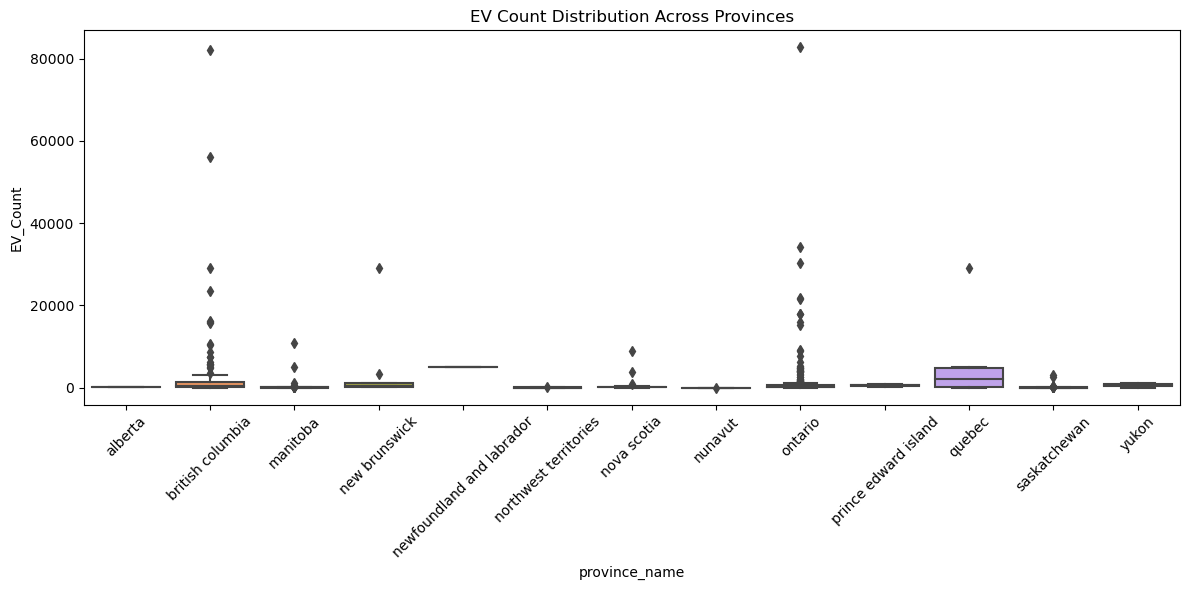

In [21]:
# Visualization of EV Count distribution across provinces
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='province_name', y='EV_Count')
plt.title('EV Count Distribution Across Provinces')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Interpretation
- The ANOVA test above shows whether EV adoption varies across provinces.
- Combined with the boxplot, it documents the statistical evidence for regional EV disparities.
- This strengthens the case for targeted rural forecasting, aligned with your experimental goals.



##  Observations

- EV adoption is **rapid and concentrated** in major provinces.
- Infrastructure growth is **not keeping pace** in many regions.
- **Rural accessibility** remains a blind spot.
- EV per station ratio is a valuable metric for pressure/load analysis.





##  Reflections

- Planning must focus not just on total EVs, but on **per-station pressure**.
- Urban-centric development creates **equity gaps**—rural areas risk being left behind.
- Visualizations like **dual-axis plots** and **geo-maps** improve stakeholder engagement.
- Data-driven decision-making can guide **scalable and inclusive infrastructure** growth.




##  Conclusion

This EDA reveals crucial trends and gaps in Canada's EV charging landscape. High-adoption provinces like Ontario and Alberta face infrastructure


### Model Development

In [22]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt


In [23]:
import pandas as pd

# Load the full car registration dataset
df_car_registration = pd.read_csv("./DataSets/DataSets/20100025.csv")

# Drop missing city entries
df_car_registration = df_car_registration.dropna(subset=["GEO"])

# Clean GEO (city) column
df_car_registration["City_clean"] = df_car_registration["GEO"].str.strip().str.lower()

# Filter for EV types
ev_df = df_car_registration[
    df_car_registration["Fuel type"].isin(["Battery electric", "Plug-in hybrid electric"])
]

# Convert REF_DATE to datetime (monthly)
ev_df["REF_DATE"] = pd.to_datetime(ev_df["REF_DATE"], errors="coerce")

# Optional: Rename GEO to City
ev_df = ev_df.rename(columns={"GEO": "City"})




C:\Users\divya\AppData\Local\Temp\ipykernel_26688\1652905942.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_car_registration = pd.read_csv("./DataSets/DataSets/20100025.csv")
C:\Users\divya\AppData\Local\Temp\ipykernel_26688\1652905942.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_df["REF_DATE"] = pd.to_datetime(ev_df["REF_DATE"], errors="coerce")


In [24]:
city_df = pd.read_csv("./DataSets/DataSets/canadacities.csv")
# df_stations = pd.read_csv("./DataSets\DataSets\stations_detail.csv")

# 80/20 split
split_idx = int(len(city_df) * 0.8)
train = city_df.iloc[:split_idx]
test = city_df.iloc[split_idx:]


In [25]:
# Example for one rural city, e.g. Pembroke
city_name = 'Pembroke'

# Filter and group data by month
city_df = ev_df[ev_df["City"] == city_name].copy()
city_df = city_df.groupby("REF_DATE")["VALUE"].sum().reset_index()

# Rename columns for Prophet
city_df.columns = ["ds", "y"]  # Prophet requires 'ds' and 'y'
city_df = city_df.dropna()


In [26]:
# Train-test split (80/20)
split_idx = int(len(city_df) * 0.8)
train = city_df.iloc[:split_idx]
test = city_df.iloc[split_idx:]

# Fit Prophet model
from prophet import Prophet
model = Prophet()
model.fit(train)


07:25:46 - cmdstanpy - INFO - Chain [1] start processing
07:25:46 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
print(city_df.head())
print(city_df.dtypes)


          ds    y
0 2017-01-01  0.0
1 2017-04-01  2.0
2 2017-07-01  2.0
3 2017-10-01  4.0
4 2018-01-01  0.0
ds    datetime64[ns]
y            float64
dtype: object


In [28]:
from prophet import Prophet

model = Prophet()
model.fit(city_df)


07:25:47 - cmdstanpy - INFO - Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing


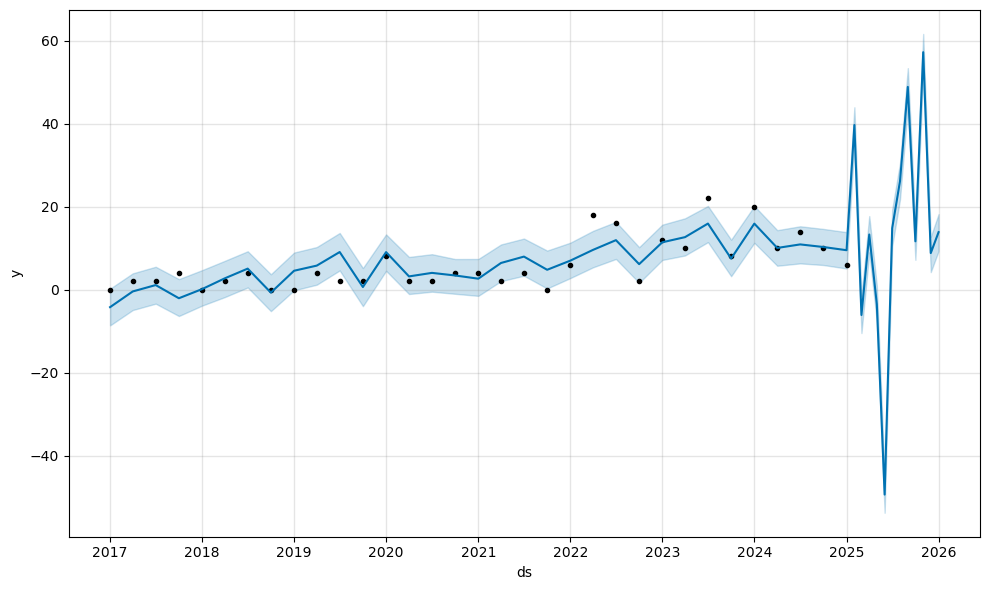

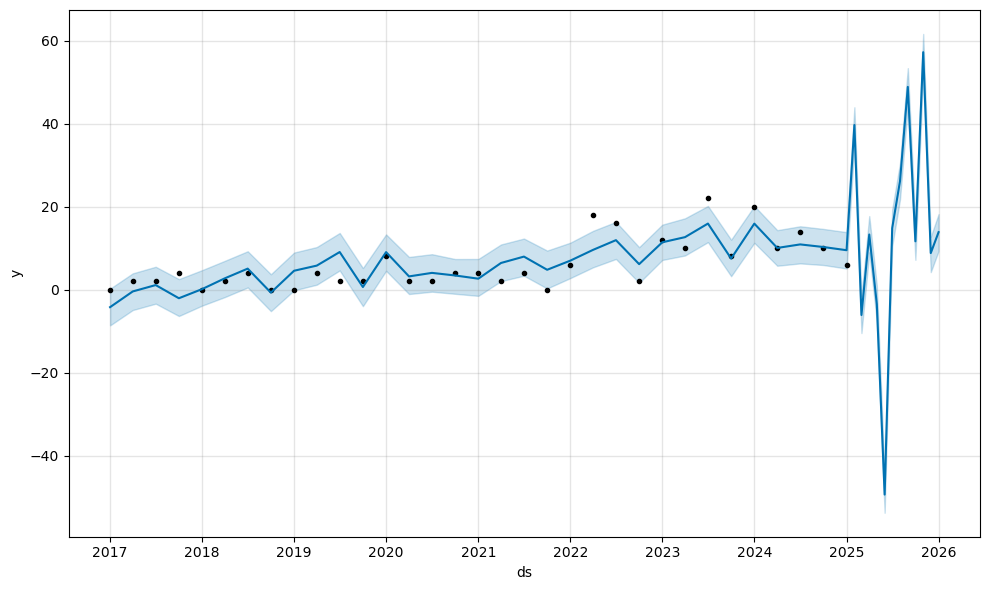

In [29]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

model.plot(forecast)


In [30]:
from prophet import Prophet
from prophet.plot import plot_plotly
import pandas as pd
import matplotlib.pyplot as plt

def forecast_ev_demand(city_df, city_name, periods=8):
    model = Prophet()
    model.fit(city_df)
    future = model.make_future_dataframe(periods=periods, freq='Q')
    forecast = model.predict(future)

    # Plot using matplotlib or use plotly for interactive version
    fig = model.plot(forecast)
    plt.title(f"EV Demand Forecast for {city_name}")
    plt.xlabel("Date")
    plt.ylabel("EV Registrations")
    plt.show()
    
    return forecast


07:25:48 - cmdstanpy - INFO - Chain [1] start processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing


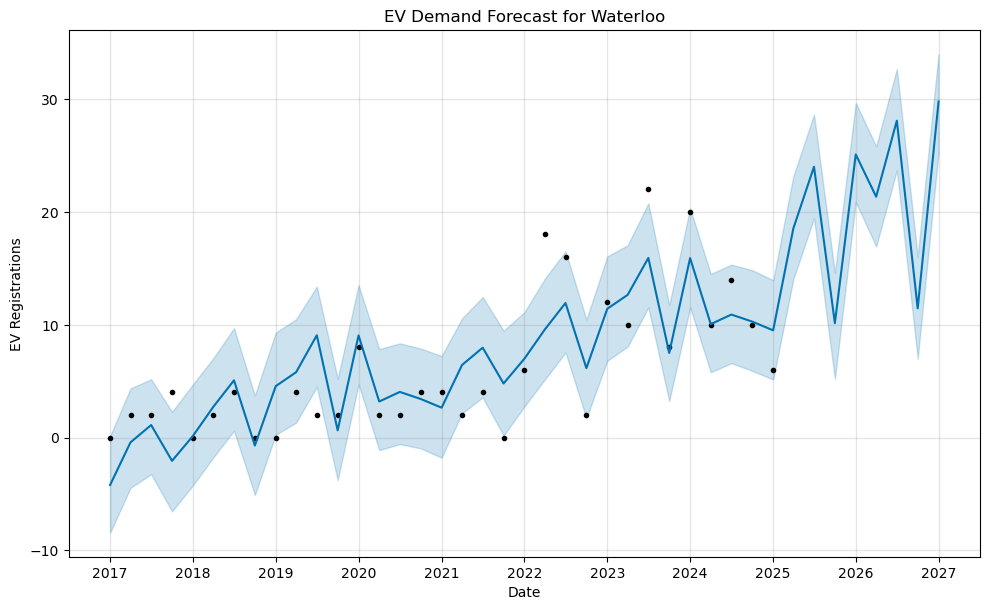

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,0.929357,-8.438764,0.134770,0.929357,0.929357,-5.137112,-5.137112,-5.137112,-5.137112,-5.137112,-5.137112,0.0,0.0,0.0,-4.207755
1,2017-04-01,1.351667,-4.456990,4.357336,1.351667,1.351667,-1.776787,-1.776787,-1.776787,-1.776787,-1.776787,-1.776787,0.0,0.0,0.0,-0.425120
2,2017-07-01,1.778669,-3.252248,5.166650,1.778669,1.778669,-0.668098,-0.668098,-0.668098,-0.668098,-0.668098,-0.668098,0.0,0.0,0.0,1.110571
3,2017-10-01,2.210364,-6.540522,2.281507,2.210364,2.210364,-4.274412,-4.274412,-4.274412,-4.274412,-4.274412,-4.274412,0.0,0.0,0.0,-2.064048
4,2018-01-01,2.642058,-4.240190,4.711116,2.642058,2.642058,-2.504634,-2.504634,-2.504634,-2.504634,-2.504634,-2.504634,0.0,0.0,0.0,0.137424
5,2018-04-01,3.064368,-1.764860,7.034561,3.064368,3.064368,-0.337432,-0.337432,-0.337432,-0.337432,-0.337432,-0.337432,0.0,0.0,0.0,2.726936
6,2018-07-01,3.491370,0.608876,9.691819,3.491370,3.491370,1.578758,1.578758,1.578758,1.578758,1.578758,1.578758,0.0,0.0,0.0,5.070128
7,2018-10-01,3.923065,-5.087969,3.717795,3.923065,3.923065,-4.628888,-4.628888,-4.628888,-4.628888,-4.628888,-4.628888,0.0,0.0,0.0,-0.705824
8,2019-01-01,4.354759,0.254126,9.298442,4.354759,4.354759,0.202618,0.202618,0.202618,0.202618,0.202618,0.202618,0.0,0.0,0.0,4.557377
9,2019-04-01,4.777069,1.327240,10.484808,4.777069,4.777069,1.017719,1.017719,1.017719,1.017719,1.017719,1.017719,0.0,0.0,0.0,5.794788


In [31]:
forecast_ev_demand(city_df, city_name="Waterloo")


In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Split into train/test
train = city_df.iloc[:-4]
test = city_df.iloc[-4:]

model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=4, freq='Q')
forecast = model.predict(future)

# Evaluation
pred = forecast[-4:]["yhat"].values
true = test["y"].values

mae = mean_absolute_error(true, pred)
mape = mean_absolute_percentage_error(true, pred)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}")


07:25:49 - cmdstanpy - INFO - Chain [1] start processing
07:25:49 - cmdstanpy - INFO - Chain [1] done processing


MAE: 6.96, MAPE: 87.34%
